In [1]:
import cv2  
import os  
import sys  
import numpy as np
import random  
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import pandas
from tqdm import tqdm

In [2]:
ddi_data_csv = pandas.read_csv('ddi_metadata.csv',index_col=0)
ddi_data_csv.head()

,DDI_ID,DDI_file,skin_tone,malignant,disease
0,1,000001.png,56,True,melanoma-in-situ
1,2,000002.png,56,True,melanoma-in-situ
2,3,000003.png,56,True,mycosis-fungoides
3,4,000004.png,56,True,squamous-cell-carcinoma-in-situ
4,5,000005.png,12,True,basal-cell-carcinoma


In [3]:
img_list = list(ddi_data_csv['DDI_file'])
for i in img_list:
    assert os.path.exists(os.path.join('ddidiversedermatologyimages',i))
img_list = [os.path.join('ddidiversedermatologyimages',i) for i in img_list]

In [4]:
malignant_cls = [1 if i == True else 0 for i in list(ddi_data_csv['malignant'])] #[0,0,1,1,]
disease_cls = [i for i in list(ddi_data_csv['disease'])]

In [5]:
#这里为了更好的选出好的滤波器，我们选择了调节参数选择了24个滤波器，选择一个滤波效果最好的滤波器最好的
def build_filters():
     filters = []
     ksize = [7,9,11,13,15,17] # gabor尺度，6个
     lamda = np.pi/2.0         # 波长
     for theta in np.arange(0, np.pi, np.pi / 4): #gabor方向，0°，45°，90°，135°，共四个
         for K in range(6):
            
                 kern = cv2.getGaborKernel((ksize[K], ksize[K]), 1.0, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
                 kern /= 1.5*kern.sum()
                 filters.append(kern)
     plt.figure(1)

     #用于绘制滤波器
     #for temp in range(len(filters)):
     #    plt.subplot(4, 6, temp + 1)
     #    plt.imshow(filters[temp])
    # plt.show()
     return filters


#Gabor特征提取
def getGabor(img,filters):
    res = [] #滤波结果
    for i in range(len(filters)):
        # res1 = process(img, filters[i])
        accum = np.zeros_like(img)
        for kern in filters[i]:
            fimg = cv2.filter2D(img, cv2.CV_8UC1, kern)
            accum = np.maximum(accum, fimg, accum)
        res.append(np.asarray(accum))
   # print(res)
    #用于绘制滤波效果
    plt.figure(2)
    for temp in range(len(res)):
        plt.subplot(4,6,temp+1)
        plt.imshow(res[temp], cmap='gray' )
   # plt.show()
    return res  #返回滤波结果,结果为24幅图，按照gabor角度排列
filters = build_filters()

<Figure size 432x288 with 0 Axes>

[[(285, 306), 28, 0],
 [(285, 306), 26, 0],
 [(285, 306), 26, 0],
 [(285, 306), 26, 0],
 [(285, 306), 26, 0],
 [(285, 306), 26, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0],
 [(285, 306), 255, 0]]

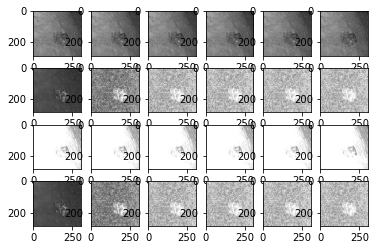

In [6]:
img = cv2.imread( img_list[3],cv2.IMREAD_GRAYSCALE)
[[i.shape,i.max(),i.min()] for i in getGabor(img,filters)]

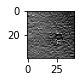

In [7]:
filters = filters[3:4]
resized_img = cv2.resize(img,(40,40))
res = getGabor(resized_img,filters)

100%|████████████████████████████████████████| 656/656 [00:06<00:00, 106.40it/s]


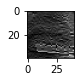

In [8]:
feature_list = []
for i in tqdm(img_list):
    img = cv2.imread( i,cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(40,40)) 
    res = getGabor(resized_img,filters)[0].reshape(1600)
    feature_list.append(list(res))

In [10]:
featuremap_pd = pandas.DataFrame(columns=['img_name','malignant_cls','disease_cls']+[i for i in range(1600)])

In [11]:
for idx,i in tqdm(enumerate(img_list)):
    content = {'img_name':os.path.basename(i),
                'malignant_cls':malignant_cls[idx],
                'disease_cls':disease_cls[idx]}
    feature_dict = {ids:j for ids,j in enumerate(feature_list[idx])}
    total = {}
    total.update(feature_dict)
    total.update(content)
    featuremap_pd = featuremap_pd.append(total,ignore_index=True)

656it [00:45, 14.42it/s]


In [12]:
pandas.value_counts(disease_cls).to_json()

'{"melanocytic-nevi":119,"seborrheic-keratosis":58,"verruca-vulgaris":50,"basal-cell-carcinoma":41,"epidermal-cyst":35,"mycosis-fungoides":32,"squamous-cell-carcinoma-in-situ":28,"dermatofibroma":22,"acrochordon":19,"squamous-cell-carcinoma":17,"dysplastic-nevus":16,"pyogenic-granuloma":14,"seborrheic-keratosis-irritated":14,"neurofibroma":12,"angioma":11,"eccrine-poroma":10,"squamous-cell-carcinoma-keratoacanthoma":8,"melanoma":7,"melanoma-acral-lentiginous":7,"kaposi-sarcoma":6,"molluscum-contagiosum":6,"nevus-lipomatosus-superficialis":6,"melanoma-in-situ":6,"basal-cell-carcinoma-nodular":6,"blue-nevus":6,"lipoma":6,"inverted-follicular-keratosis":5,"metastatic-carcinoma":5,"prurigo-nodularis":5,"eczema-spongiotic-dermatitis":4,"actinic-keratosis":4,"solar-lentigo":4,"arteriovenous-hemangioma":3,"hyperpigmentation":3,"trichilemmoma":3,"abrasions-ulcerations-and-physical-injuries":3,"benign-keratosis":3,"xanthogranuloma":2,"graft-vs-host-disease":2,"condyloma-accuminatum":2,"fibrous-

In [13]:
preserve_cls = ['melanocytic-nevi','seborrheic-keratosis','verruca-vulgaris','basal-cell-carcinoma']

In [14]:
disease_featuremap=[]
disease_cls_idx=[]
for idx,i in enumerate(disease_cls):
    if i in preserve_cls:
        disease_featuremap.append(feature_list[idx])
        disease_cls_idx.append(preserve_cls.index(i))

# Classification

### Random Forest

#### RF - Binary Model

In [30]:
from sklearn.ensemble import RandomForestClassifier as rfc
import sklearn.datasets as skdata
import matplotlib.pyplot as plt
from sklearn.model_selection  import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [19]:
data_x,data_y = feature_list,malignant_cls

In [67]:
#cross-validation method
cv = KFold(n_splits=5, random_state=20, shuffle=True)

#build RF model
model_rfc = rfc()

#use k-fold CV to evaluate model
rf_accu = cross_val_score(model_rfc, data_x, data_y, scoring='accuracy', cv=cv, n_jobs=-1)
rf_pres = cross_val_score(model_rfc, data_x, data_y, scoring='precision', cv=cv, n_jobs=-1)
rf_f1 = cross_val_score(model_rfc, data_x, data_y, scoring='f1', cv=cv, n_jobs=-1)
rf_recal = cross_val_score(model_rfc, data_x, data_y, scoring='recall', cv=cv, n_jobs=-1)
rf_roc = cross_val_score(model_rfc, data_x, data_y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [68]:
np.mean(rf_accu)

0.7423201480453387

In [69]:
np.mean(rf_pres)

0.5833333333333333

In [70]:
np.mean(rf_f1)

0.1449310405407966

In [71]:
np.mean(rf_recal)

0.04057941696188122

In [72]:
np.mean(rf_roc)

0.5774986119981936

#### RF Multi-Class Model

In [20]:
mul_data_x, mul_data_y = disease_featuremap, disease_cls_idx

In [54]:
#cross-validation method
cv = KFold(n_splits=5, random_state=20, shuffle=True)

#build RF model
model_rfc = rfc()

#use k-fold CV to evaluate model
mrf_accu = cross_val_score(model_rfc, mul_data_x, mul_data_y, scoring='accuracy', cv=cv)
mrf_pres = cross_val_score(model_rfc, mul_data_x, mul_data_y, scoring='precision_macro', cv=cv)
mrf_f1 = cross_val_score(model_rfc, mul_data_x, mul_data_y, scoring='f1_macro', cv=cv)
mrf_recal = cross_val_score(model_rfc, mul_data_x, mul_data_y, scoring='recall_macro', cv=cv)

/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
np.mean(mrf_accu)

0.3914046121593291

In [56]:
np.mean(mrf_pres)

0.2405055127938423

In [57]:
np.mean(mrf_f1)

0.24159157610105747

In [58]:
np.mean(mrf_recal)

0.24666666666666667

### Decision Tree

#### DT - Binary Model

In [17]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.datasets as skdata
import matplotlib.pyplot as plt
from sklearn.model_selection  import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,roc_auc_score

In [62]:
#cross-validation method
cv = KFold(n_splits=5, random_state=20, shuffle=True)

#build RF model
model_dt = DecisionTreeClassifier()

#use k-fold CV to evaluate model
dt_accu = cross_val_score(model_dt, data_x, data_y, scoring='accuracy', cv=cv, n_jobs=-1)
dt_pres = cross_val_score(model_dt, data_x, data_y, scoring='precision', cv=cv, n_jobs=-1)
dt_f1 = cross_val_score(model_dt, data_x, data_y, scoring='f1', cv=cv, n_jobs=-1)
dt_recal = cross_val_score(model_dt, data_x, data_y, scoring='recall', cv=cv, n_jobs=-1)
dt_roc = cross_val_score(model_dt, data_x, data_y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [63]:
np.mean(dt_accu)

0.6111612306268794

In [64]:
np.mean(dt_pres)

0.28766901526229793

In [65]:
np.mean(dt_f1)

0.29806999203252355

In [66]:
np.mean(dt_recal)

0.3222036916685781

In [67]:
np.mean(dt_roc)

0.5239010764718336

#### DT - Multi Class Model

In [69]:
#cross-validation method
cv = KFold(n_splits=5, random_state=20, shuffle=True)

#build DT model
model_dt = DecisionTreeClassifier()

#use k-fold CV to evaluate model
mdt_accu = cross_val_score(model_dt, mul_data_x, mul_data_y, scoring='accuracy', cv=cv)
mdt_pres = cross_val_score(model_dt, mul_data_x, mul_data_y, scoring='precision_macro', cv=cv)
mdt_f1 = cross_val_score(model_dt, mul_data_x, mul_data_y, scoring='f1_macro', cv=cv)
mdt_recal = cross_val_score(model_dt, mul_data_x, mul_data_y, scoring='recall_macro', cv=cv)

In [70]:
np.mean(mdt_accu)

0.3504542278127184

In [71]:
np.mean(mdt_pres)

0.23186025851214637

In [72]:
np.mean(mdt_f1)

0.2616830425183588

In [73]:
np.mean(mdt_recal)

0.28831998556998556

### Support Vector Machine

#### SVM - Binary Model

In [73]:
from sklearn.svm import SVC

cv = KFold(n_splits=5, random_state=20, shuffle=True)

model_svm = SVC(kernel ='rbf', random_state = 0)

svm_accu = cross_val_score(model_svm, data_x, data_y, scoring='accuracy', cv=cv, n_jobs=-1)
svm_pres = cross_val_score(model_svm, data_x, data_y, scoring='precision', cv=cv, n_jobs=-1)
svm_f1 = cross_val_score(model_svm, data_x, data_y, scoring='f1', cv=cv, n_jobs=-1)
svm_recal = cross_val_score(model_svm, data_x, data_y, scoring='recall', cv=cv, n_jobs=-1)
svm_roc = cross_val_score(model_svm, data_x, data_y, scoring='roc_auc', cv=cv, n_jobs=-1)

/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
np.mean(svm_accu)

0.7423085820032385

In [75]:
np.mean(svm_pres)

0.4

In [76]:
np.mean(svm_f1)

0.025098039215686273

In [77]:
np.mean(svm_recal)

0.012957157784743992

In [78]:
np.mean(svm_roc)

0.549755671567049

#### SVM - Multi Class

In [49]:
cv = KFold(n_splits=5, random_state=20, shuffle=True)

model_svm = SVC(kernel ='rbf', random_state = 0)

msvm_accu = cross_val_score(model_svm, mul_data_x, mul_data_y, scoring='accuracy', cv=cv)
msvm_pres = cross_val_score(model_svm, mul_data_x, mul_data_y, scoring='precision_macro', cv=cv)
msvm_f1 = cross_val_score(model_svm, mul_data_x, mul_data_y, scoring='f1_macro', cv=cv)
msvm_recal = cross_val_score(model_svm, mul_data_x, mul_data_y, scoring='recall_macro', cv=cv)

/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suetlingku/opt/anaconda3/lib/python3

In [50]:
np.mean(msvm_accu)

0.4401816911250874

In [51]:
np.mean(msvm_pres)

0.11046470999301188

In [52]:
np.mean(msvm_f1)

0.15263257348396936

In [53]:
np.mean(msvm_recal)

0.248

### Naive Bayes

#### Binary - Naive Bayes

In [87]:
from sklearn.naive_bayes import GaussianNB

cv = KFold(n_splits=5, random_state=20, shuffle=True)

model_gNB = GaussianNB()

nb_accu = cross_val_score(model_gNB, data_x, data_y, scoring='accuracy', cv=cv, n_jobs=-1)
nb_pres = cross_val_score(model_gNB, data_x, data_y, scoring='precision', cv=cv, n_jobs=-1)
nb_f1 = cross_val_score(model_gNB, data_x, data_y, scoring='f1', cv=cv, n_jobs=-1)
nb_recal = cross_val_score(model_gNB, data_x, data_y, scoring='recall', cv=cv, n_jobs=-1)
nb_roc = cross_val_score(model_gNB, data_x, data_y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [88]:
np.mean(nb_accu)

0.6203909322229934

In [89]:
np.mean(nb_pres)

0.30293912436769577

In [91]:
np.mean(nb_f1)

0.3188779435682378

In [92]:
np.mean(nb_recal)

0.3428319146044125

In [93]:
np.mean(nb_roc)

0.5728889875739049

#### Multi Class - Naive Bayes

In [94]:
cv = KFold(n_splits=5, random_state=20, shuffle=True)

model_gNB = GaussianNB()

mgNB_accu = cross_val_score(model_gNB, mul_data_x, mul_data_y, scoring='accuracy', cv=cv)
mgNB_pres = cross_val_score(model_gNB, mul_data_x, mul_data_y, scoring='precision_macro', cv=cv)
mgNB_f1 = cross_val_score(model_gNB, mul_data_x, mul_data_y, scoring='f1_macro', cv=cv)
mgNB_recal = cross_val_score(model_gNB, mul_data_x, mul_data_y, scoring='recall_macro', cv=cv)

In [95]:
np.mean(mgNB_accu)

0.34723969252271136

In [96]:
np.mean(mgNB_pres)

0.26709812178562176

In [97]:
np.mean(mgNB_f1)

0.2579687639480032

In [98]:
np.mean(mgNB_recal)

0.27992424242424246

### K-Nearest Neighbour

#### Binary - KNN

In [115]:
from sklearn.neighbors import KNeighborsClassifier

cv = KFold(n_splits=5, random_state=20, shuffle=True)

model_kNN = KNeighborsClassifier(n_neighbors=3)

knn_accu = cross_val_score(model_kNN, data_x, data_y, scoring='accuracy', cv=cv, n_jobs=-1)
knn_pres = cross_val_score(model_kNN, data_x, data_y, scoring='precision', cv=cv, n_jobs=-1)
knn_f1 = cross_val_score(model_kNN, data_x, data_y, scoring='f1', cv=cv, n_jobs=-1)
knn_recal = cross_val_score(model_kNN, data_x, data_y, scoring='recall', cv=cv, n_jobs=-1)
knn_roc = cross_val_score(model_kNN, data_x, data_y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [116]:
np.mean(knn_accu)

0.7271108026833218

In [117]:
np.mean(knn_pres)

0.2995454545454545

In [118]:
np.mean(knn_f1)

0.1015415019762846

In [119]:
np.mean(knn_recal)

0.06310157929165498

In [120]:
np.mean(knn_roc)

0.5333574253704795

#### Multi Class - KNN

In [121]:
model_kNN = KNeighborsClassifier(n_neighbors=3)

mknn_accu = cross_val_score(model_kNN, mul_data_x, mul_data_y, scoring='accuracy', cv=cv)
mknn_pres = cross_val_score(model_kNN, mul_data_x, mul_data_y, scoring='precision_macro', cv=cv)
mknn_f1 = cross_val_score(model_kNN, mul_data_x, mul_data_y, scoring='f1_macro', cv=cv)
mknn_recal = cross_val_score(model_kNN, mul_data_x, mul_data_y, scoring='recall_macro', cv=cv)

/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suetlingku/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
np.mean(mknn_accu)

0.4064989517819706

In [123]:
np.mean(mknn_pres)

0.17681970970206265

In [124]:
np.mean(mknn_f1)

0.16931294497275187

In [125]:
np.mean(mknn_recal)

0.23922619047619045

### Extreme Gradient Boosting 

#### Binary - XGBoost

In [132]:
from xgboost import XGBClassifier
model_XGB = XGBClassifier(n_estimators=110,max_depth=300,min_child_weight=1,verbosity =0,n_jobs=16)

XGB_accu = cross_val_score(model_XGB, data_x, data_y, scoring='accuracy', cv=cv, n_jobs=-1)
XGB_pres = cross_val_score(model_XGB, data_x, data_y, scoring='precision', cv=cv, n_jobs=-1)
XGB_f1 = cross_val_score(model_XGB, data_x, data_y, scoring='f1', cv=cv, n_jobs=-1)
XGB_recal = cross_val_score(model_XGB, data_x, data_y, scoring='recall', cv=cv, n_jobs=-1)
XGB_roc = cross_val_score(model_XGB, data_x, data_y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [127]:
np.mean(XGB_accu)

0.7301064075873237

In [128]:
np.mean(XGB_pres)

0.4

In [129]:
np.mean(XGB_f1)

0.14805462348445236

In [130]:
np.mean(XGB_recal)

0.09226484780521786

In [133]:
np.mean(XGB_roc)

0.5413889174995552

#### Multi Class - XGBoost

In [134]:
model_XGB = XGBClassifier(n_estimators=110,max_depth=300,min_child_weight=1,verbosity =0,n_jobs=16)

mxgb_accu = cross_val_score(model_XGB, mul_data_x, mul_data_y, scoring='accuracy', cv=cv)
mxgb_pres = cross_val_score(model_XGB, mul_data_x, mul_data_y, scoring='precision_macro', cv=cv)
mxgb_f1 = cross_val_score(model_XGB, mul_data_x, mul_data_y, scoring='f1_macro', cv=cv)
mxgb_recal = cross_val_score(model_XGB, mul_data_x, mul_data_y, scoring='recall_macro', cv=cv)

In [135]:
np.mean(mxgb_accu)

0.4067085953878407

In [136]:
np.mean(mxgb_pres)

0.3030774382318442

In [137]:
np.mean(mxgb_f1)

0.2607202908460122

In [138]:
np.mean(mxgb_recal)

0.28312662337662337